Sudoku puzzles take place on a 9x9 grid, where the players' aim is to fill the grid with numbers such that each row, column and internal 3x3 grid contains each number, from 1 to 9, once and only once. An interesting challenge. Here we will try to use a CNN (Convolution Neural Network) to take advantage of the spatial features of the sudoku puzzle in order to train a model that can solve new, unseen sudoku starting grids. 

CNNs are designed largely for use in computer vision and are inspired by the biological neurons in the visual cortex, wherein each neuron scans only a small region of the visual field (Our 9x9 grid) and passes its information to a central layer of processing units. Hopefully such a network should be able to extract from our input data the correct spatial features and apply them to solving the problem of filling in the remaining squares.

In [85]:
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm

from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

from keras.layers import Embedding, LSTM, Dense, Dropout, Conv2D, Flatten, Reshape, BatchNormalization, Activation
from keras.models import Sequential
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
sudoku = pd.read_csv("sudoku_cluewise.csv")

print(sudoku)

                                                   quizzes  \
0        3274568919183725464659817325328641797915236848...   
1        1538972649876241532645139876327518498493625705...   
2        6851374293174928569428651738295167341567432984...   
3        8396245714207513981579382643941627852618759435...   
4        3168275944593617288724951636872543192459138769...   
...                                                    ...   
3999995  0005060000020000500600000170000000002300000000...   
3999996  0040020000000900000060000001000400000900004004...   
3999997  0000050000000001000902000000450000000600003000...   
3999998  0090000007300000055000000006000080000050000000...   
3999999  0000000090000000000800000010000000002040010306...   

                                                 solutions  clue_numbers  
0        3274568919183725464659817325328641797915236848...            80  
1        1538972649876241532645139876327518498493625715...            80  
2        685137429317492856942

Data was sourced from KAGGLE: https://www.kaggle.com/code/abdelbakiguir/sudoku-puzzles-knn-rf-99/data

Data is organised into 3 columns, the first two columns store unsolved and solved puzzles as flat strings of 81 (9x9) numbers, with the number 0 representing unsolved squares. We have access to 4,000,000 potential sudoku puzzles, ranging in difficulty from 80/81 provided clues (Extremely easy) to 17/81 provided clues (The hardest possible). Each sudoku has one solution, and one solution only.

Lets begin by inputting our data via pandas. To view what our puzzles look like, we'll write a quick couple of plot functions that will take as input the difficulty (Between 17 and 80) and unflatten the strings of unsolved puzzles and present them as they would be seen by a potential puzzle solver.

In [5]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def get_sudoku(difficulty):
    if difficulty in range(17,81,1):
        sudoku_view = sudoku[sudoku["clue_numbers"] == difficulty]
        sudoku_view = sudoku_view.sample(1)
        m = flatten(sudoku_view["quizzes"].str.split("").values.tolist())
        m.pop(0)
        m.pop(len(m)-1)
        
        df = pd.DataFrame(np.array([(x+1, y+1) for x in range(int(sqrt(len(m)))) for y in range(int(sqrt(len(m))))]), columns = ["x","y"])
        df["val"] = m
        return(df)
        
def plot_sudoku(df):    
    fig, ax = plt.subplots()
    
    cmap = ListedColormap(["w", "whitesmoke"])
    
    ax.matshow([[0,0.1,0,0.1,0,0.1,0,0.1,0],[0.1,0,0.1,0,0.1,0,0.1,0,0.1],[0,0.1,0,0.1,0,0.1,0,0.1,0],
               [0.1,0,0.1,0,0.1,0,0.1,0,0.1],[0,0.1,0,0.1,0,0.1,0,0.1,0],[0.1,0,0.1,0,0.1,0,0.1,0,0.1],
               [0,0.1,0,0.1,0,0.1,0,0.1,0],[0.1,0,0.1,0,0.1,0,0.1,0,0.1],[0,0.1,0,0.1,0,0.1,0,0.1,0]], cmap=cmap)
    
    for i in df["x"]:
        for j in df["y"]:
            idx = (df['x'] == i) & (df['y'] == j)
            t = df.loc[idx]["val"].values[0]
            ax.text(i-1,j-1,t, ha='center', va='center')
    
    plt.vlines(-0.5, -0.5, 8.5)
    plt.hlines(-0.5, -0.5, 8.5)
    plt.vlines(2.5, -0.5, 8.5)
    plt.hlines(2.5, -0.5, 8.5)
    plt.vlines(5.5, -0.5, 8.5)
    plt.hlines(5.5, -0.5, 8.5)
    plt.vlines(8.5, -0.5, 8.5)
    plt.hlines(8.5, -0.5, 8.5)
    
    plt.axis('off')
    plt.show()   
    
def splitC(word):
    return [char for char in word]

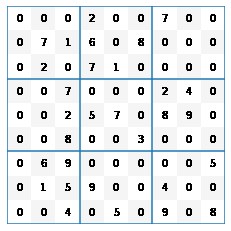

In [6]:
df = get_sudoku(30)

plot_sudoku(df)

Great. This is useful for us to get a visual representation of the problem at hand, but our CNN will simply read in the flat list of 81 numbers as its input, and will use the correct flat list of 81 numbers (Taken from the solutions column) as its label. First, we must focus on setting up our input data. We must reshape each of our strings into sudokus, as above, and then normalize them to roughly -1:1. Conveniently, we can easily normalize by dividing by 9 and subtracting 0.5.

In [37]:
solutions = sudoku["solutions"]
solutions_mat = []

for i in tqdm(solutions):
    x = np.array([int(num) for num in i]).reshape((81,1)) - 1
    solutions_mat.append(x)   
    
solutions_mat = np.array(solutions_mat)
    
quizzes = sudoku["quizzes"]
quizzes_mat = []

for i in tqdm(quizzes):
    x = np.array([int(num) for num in i]).reshape((9,9,1))
    quizzes_mat.append(x) 
        
quizzes_mat = np.array(quizzes_mat)
quizzes_mat = quizzes_mat/9
quizzes_mat -= .5

print(quizzes_mat)
print(quizzes_mat.shape)

100%|█████████████████████████████████████████████████████████████████████| 4000000/4000000 [01:25<00:00, 46952.25it/s]


[[[[-0.16666667]
   [-0.27777778]
   [ 0.27777778]
   ...
   [ 0.38888889]
   [ 0.5       ]
   [-0.38888889]]

  [[ 0.5       ]
   [-0.38888889]
   [ 0.38888889]
   ...
   [ 0.05555556]
   [-0.05555556]
   [ 0.16666667]]

  [[-0.05555556]
   [ 0.16666667]
   [ 0.05555556]
   ...
   [ 0.27777778]
   [-0.16666667]
   [-0.27777778]]

  ...

  [[ 0.16666667]
   [ 0.05555556]
   [-0.16666667]
   ...
   [ 0.5       ]
   [-0.27777778]
   [ 0.27777778]]

  [[-0.27777778]
   [ 0.27777778]
   [ 0.5       ]
   ...
   [-0.05555556]
   [-0.38888889]
   [ 0.38888889]]

  [[-0.38888889]
   [ 0.38888889]
   [-0.05555556]
   ...
   [-0.16666667]
   [ 0.16666667]
   [ 0.05555556]]]


 [[[-0.38888889]
   [ 0.05555556]
   [-0.16666667]
   ...
   [-0.27777778]
   [ 0.16666667]
   [-0.05555556]]

  [[ 0.5       ]
   [ 0.38888889]
   [ 0.27777778]
   ...
   [-0.38888889]
   [ 0.05555556]
   [-0.16666667]]

  [[-0.27777778]
   [ 0.16666667]
   [-0.05555556]
   ...
   [ 0.5       ]
   [ 0.38888889]
   [ 0.2777

In [38]:
print(quizzes_mat.shape)
print(solutions_mat.shape)

(4000000, 9, 9, 1)
(4000000, 81, 1)


Great, now for the test/train split. As for the model design, we are a little constrained by our computing power, but we'll try to use as many reltively large convolutional network layers as possible. Our model is inspired by Akin-David et al. (2018).

In [41]:
x = quizzes_mat
y = solutions_mat

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=42, stratify=sudoku["clue_numbers"])

In [42]:
print(x_train.shape)

(3200000, 9, 9, 1)


In [ ]:
def create_model():
    model = Sequential()
    #We use 5 layers of Convolutional nodes, with 64 filters and a 3x3 kernel.
    #3x3 kernels are typicl for performance and accuracy, and also lend themselves very well to the 9x9 sudoku puzzle
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(9,9,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(1,1), activation='relu', padding='same'))
    
    #We flatten our last CNN layer and connect to an 81*9 dense layer, as we have 81 slots with 9 possible predictions
    model.add(Flatten())
    model.add(Dense(81*9))
    
    #We reshape our solution into a readable form, and activate with softmax to provide a probabilistic estimate
    model.add(Reshape((-1, 9)))
    model.add(Activation('softmax'))
    
    adam = keras.optimizers.Adam(learning_rate=.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [50]:
model = create_model()

history = model.fit(x_train,y_train,epochs=2,batch_size=64)

Epoch 1/2
50000/50000 [==============================] - 4714s 94ms/step - loss: 0.3661 - accuracy: 0.8351
Epoch 2/2
50000/50000 [==============================] - 5304s 106ms/step - loss: 0.3274 - accuracy: 0.8511


After 2 epochs it seems that our loss is stabilizing around 0.325, with an accuracy of 85%. Not terrible, but not great.

We could use the module show_keras_history to very quickly graph some of the stats of our training model, but due to the low number of epochs, this is a very boring graph...

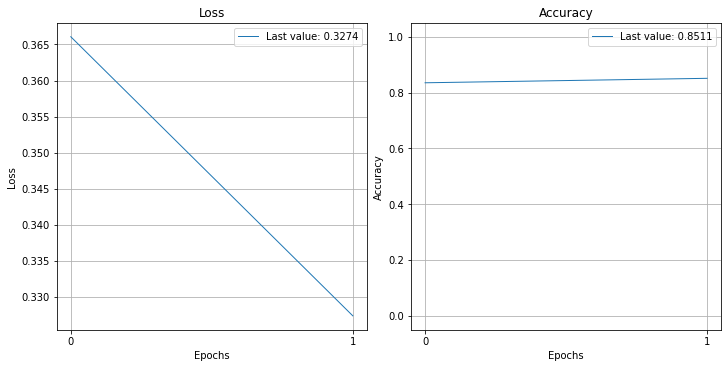

In [53]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

Let's view a couple of unsolved and then solved sudoku puzzles:

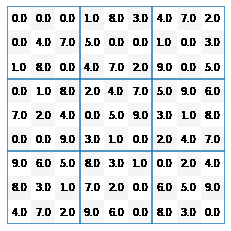

In [83]:
m = flatten(((x_train.squeeze()[354]+0.5)*9))

df = pd.DataFrame(np.array([(x+1, y+1) for x in range(int(sqrt(len(m)))) for y in range(int(sqrt(len(m))))]), columns = ["x","y"])

df["val"] = m

plot_sudoku(df)

1/1 [==============================] - 0s 23ms/step


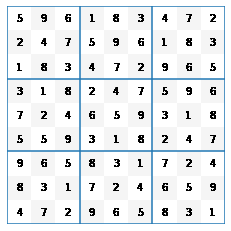

In [82]:
m = model.predict(x_train[354].reshape((1,9,9,1))).squeeze()

m = flatten(np.argmax(m, axis=1).reshape((9,9))+1)

df = pd.DataFrame(np.array([(x+1, y+1) for x in range(int(sqrt(len(m)))) for y in range(int(sqrt(len(m))))]), columns = ["x","y"])

df["val"] = m

plot_sudoku(df)

Hurray, looks solved!